<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/TransferLearning_Transfer_learning_with_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with MobileNetV2

In this project, transfer learning will be used on a pre-trained CNN to build an **Alpaca/Not Alpaca** classifier.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/images/alpaca.png?raw=true" style="width:300px;height:220px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize our own model cheaply and efficiently. MobileNetV2, was designed to provide fast and computationally efficient performance. The model is pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

In [1]:
# importing relevant packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Create the dataset and split it into training and validation sets


In [2]:
# !unzip dataset.zip

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Looking at the images

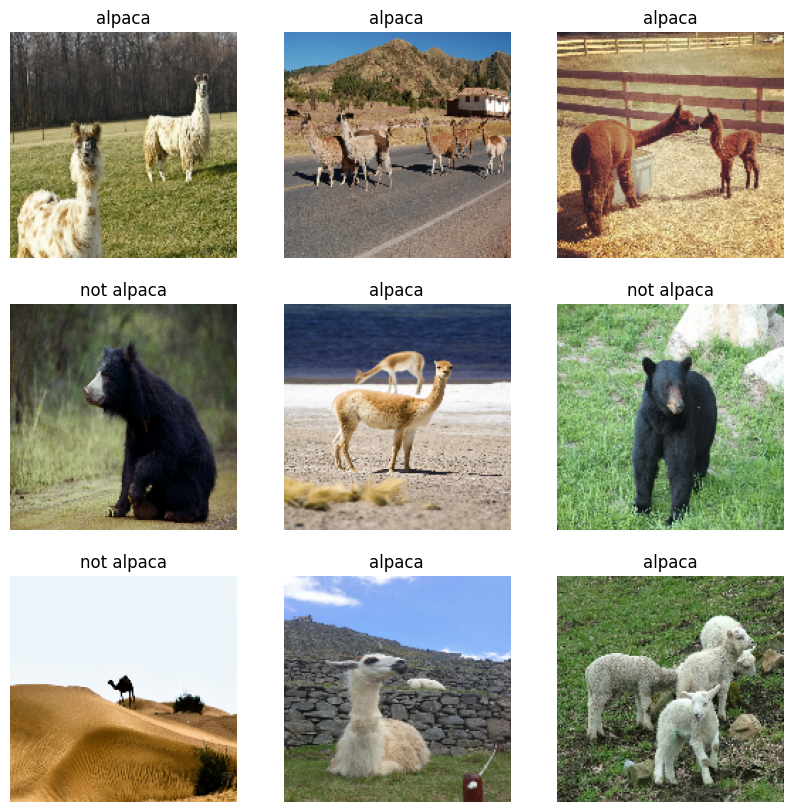

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Since, the dataset is streaming, the data doesn't need to fit into memory.

Number of elements to prefetch can be set manually, or we can use `tf.data.experimental.AUTOTUNE` to chose the parameters experimentally. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those time into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentation, with buil-in, customizable preprocessing layers. These layers are saved with the rest of our model and can be re-used later.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers.

    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

Taking a look at how an image from the training set has been augmented with simple transformations:

From one cute animal, to 9 variations of the cute animal. Now our model has a lot more to learn from.

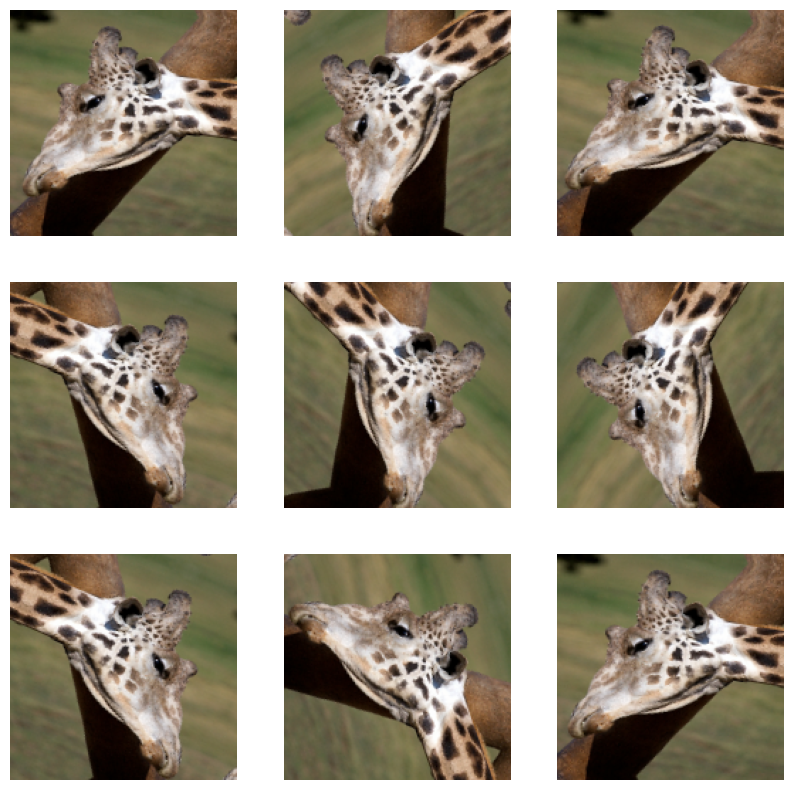

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255.0)
        plt.axis('off')

Now, we can use our tool from MobileNet application in TensorFlow, to normalize our input. Since, we are using a pre-trained model that was trained on the normalization values [-1, 1], it's best practice to reuse that standard with `tf.keras.applications.mobilenet_v2.preprocess_input`.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Usinge MobileNetV2 for Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-powered applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks. The architecture has three defining characteristics:

- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

### Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 uses a depthwise separable convolutions as efficient builing blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of traniable parameters and operations and also speed up convolution in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.
2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters**.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/images/mobilenetv2.png?raw=true" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

Let's try to train your base model using all the layers from the pretrained model.

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`.

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


Print the model summary below to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable.

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

The last 2 layers here are so called top layers, and they are responsible of the classification in the model

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images.

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [14]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582163),
  ('n02708093', 'analog_clock', 0.092755675)],
 [('n04589890', 'window_screen', 0.23985945),
  ('n03887697', 'paper_towel', 0.14802651)],
 [('n04589890', 'window_screen', 0.7449457),
  ('n03598930', 'jigsaw_puzzle', 0.021948567)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.07628971)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.6745237),
  ('n03530642', 'honeycomb', 0.076599084)],
 [('n04589890', 'window_screen', 0.7912854),
  ('n04209239', 'shower_curtain', 0.092416056)],
 [('n04589890', 'window_screen', 0.16462995),
  ('n03598930', 'jigsaw_puzzle', 0.08749132)],
 [('n03598930', 'jigsaw_puzzle', 0.37021285),
  ('n04589890', 'window_screen', 0.09956944)],
 [('n04589890', 'window_screen', 0.616165),
  ('n03887697', 'paper_towel', 0.054876428)],
 [('n03530642', 'honeycomb', 0.25448847),
  ('n04589890', 'window_screen', 0.24874288)],
 [('

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.

## Layer Freezing with the Functional API

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/TransferLearning/images/snowalpaca.png?raw=true" style="width:400px;height:250px;">

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps:

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [15]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

Create your new model using the data_augmentation function defined earlier.

In [16]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 0s 0us/step


The base learning rate has been set for us, so now we can go ahead and compile the new model and run it for 5 epochs:

In [18]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 15s 998ms/step - loss: 0.6984 - accuracy: 0.6603 - val_loss: 0.2666 - val_accuracy: 0.8000
Epoch 2/5
9/9 [==============================] - 10s 954ms/step - loss: 0.4076 - accuracy: 0.7901 - val_loss: 0.1184 - val_accuracy: 0.9846
Epoch 3/5
9/9 [==============================] - 9s 823ms/step - loss: 0.2821 - accuracy: 0.8740 - val_loss: 0.1468 - val_accuracy: 0.8923
Epoch 4/5
9/9 [==============================] - 10s 923ms/step - loss: 0.2054 - accuracy: 0.9237 - val_loss: 0.0568 - val_accuracy: 0.9846
Epoch 5/5
9/9 [==============================] - 10s 893ms/step - loss: 0.2104 - accuracy: 0.9046 - val_loss: 0.0639 - val_accuracy: 0.9846


Plot the training and validation accuracy:

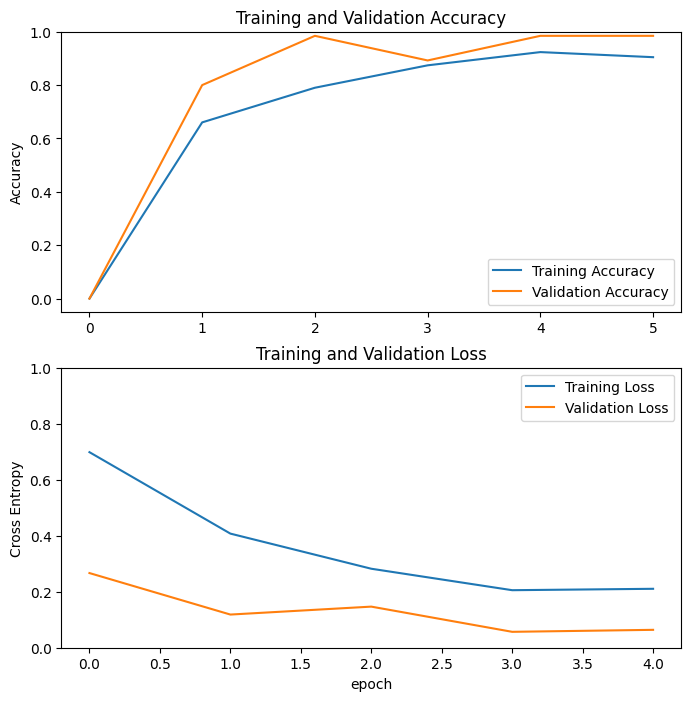

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

## Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

##### One Way ########
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""

######## Other Way ######
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = None

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001

# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [25]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 15s 970ms/step - loss: 0.1430 - accuracy: 0.9466 - val_loss: 0.0572 - val_accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 10s 855ms/step - loss: 0.1576 - accuracy: 0.9313 - val_loss: 0.0608 - val_accuracy: 0.9846
Epoch 7/10
9/9 [==============================] - 10s 957ms/step - loss: 0.1598 - accuracy: 0.9389 - val_loss: 0.0557 - val_accuracy: 1.0000
Epoch 8/10
9/9 [==============================] - 10s 950ms/step - loss: 0.1120 - accuracy: 0.9580 - val_loss: 0.0554 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 9s 837ms/step - loss: 0.1853 - accuracy: 0.9237 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 10/10
9/9 [==============================] - 9s 761ms/step - loss: 0.1416 - accuracy: 0.9427 - val_loss: 0.0595 - val_accuracy: 0.9846


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

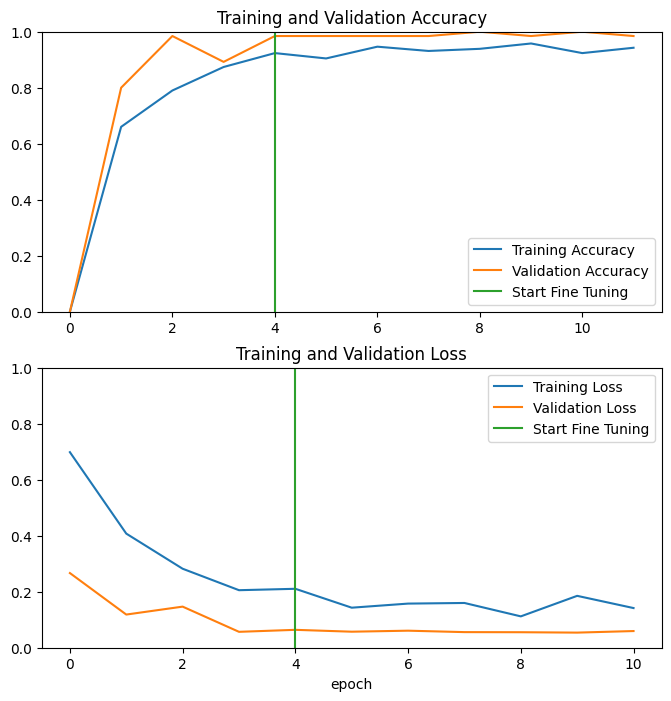

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()